## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path ='drive/MyDrive/Code/Scripts/'
path_data ='drive/MyDrive/Data/'

import sys, os, random
sys.path.append(path)

import h5py
import pickle
import numpy as np
import pandas as pd
from scipy.special import logsumexp
import matplotlib.pyplot as plt

import tensorflow as tf
from Model import MonkeyClassifier
from Visualization import *
from Utils import *

seed=42

Mounted at /content/drive


## Setting Seeds

In [2]:
def seed_everything(seed):
  os.environ['PYTHONHASHSEED']=str(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

def set_global_determinism(seed):
  seed_everything(seed=seed)

  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
  tf.config.threading.set_inter_op_parallelism_threads(1)
  tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed)

## Exploring Data

In [3]:
IMAGE_SHAPE= (224,224,3)
BATCH_SIZE= 64

train_dir= path_data+'Monkey_Data/training/training'
test_dir= path_data+'Monkey_Data/validation/validation'
labels_dir= path_data+'Monkey_Data/monkey_labels.txt'

monkey_labels= pd.read_csv(labels_dir)
monkey_labels.columns = [c.strip() for c in monkey_labels.columns]
monkey_labels['Label'] = monkey_labels['Label'].str.strip()
monkey_labels['Latin Name'] = monkey_labels['Latin Name'].str.strip()
monkey_labels['Common Name'] = monkey_labels['Common Name'].str.strip()
monkey_labels

Label             Latin Name  ... Train Images  Validation Images
0    n0      alouatta_palliata  ...          131                 26
1    n1     erythrocebus_patas  ...          139                 28
2    n2         cacajao_calvus  ...          137                 27
3    n3         macaca_fuscata  ...          152                 30
4    n4        cebuella_pygmea  ...          131                 26
5    n5        cebus_capucinus  ...          141                 28
6    n6        mico_argentatus  ...          132                 26
7    n7       saimiri_sciureus  ...          142                 28
8    n8        aotus_nigriceps  ...          133                 27
9    n9  trachypithecus_johnii  ...          132                 26

[10 rows x 5 columns]

### Plot Count Distribution of Labels

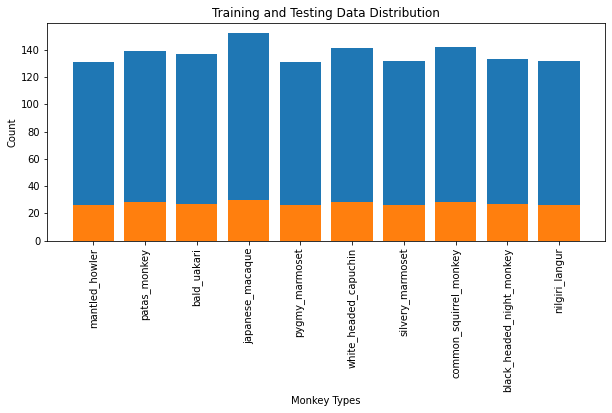

In [4]:
plt.figure(figsize=(10,4))
plt.bar(range(len(monkey_labels['Train Images'])), monkey_labels['Train Images'])
plt.bar(range(len(monkey_labels['Validation Images'])), monkey_labels['Validation Images'])
plt.xticks(range(len(monkey_labels['Common Name'])), monkey_labels['Common Name'], rotation=90)
plt.xlabel('Monkey Types')
plt.ylabel('Count')
plt.title('Training and Testing Data Distribution')
plt.show()

### Visualising Dataset

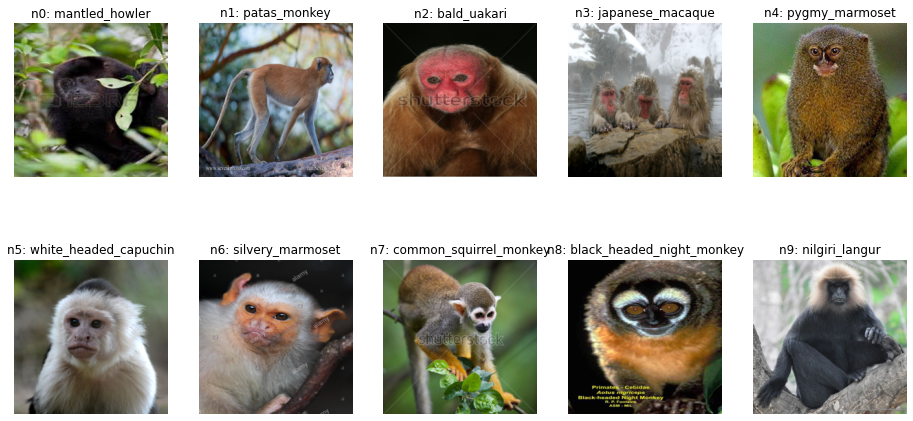

In [5]:
# Title in the form of [Class Folder Name]: [Common Name]
plot_grid(rows=2, cols=5, figsize=(16,8),
          image_root_path=train_dir, labels=monkey_labels, data_shape=IMAGE_SHAPE[:2])

In [6]:
# Selecting classes of monkey to train
class_filter = ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6']
label_mapping = monkey_labels['Common Name'][:7].to_dict() # Get class folder name -> common name mapping b
label_mapping

{0: 'mantled_howler',
 1: 'patas_monkey',
 2: 'bald_uakari',
 3: 'japanese_macaque',
 4: 'pygmy_marmoset',
 5: 'white_headed_capuchin',
 6: 'silvery_marmoset'}

## Training

In [7]:
train_dataset = MonkeyData(path=train_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TRAIN,
                        batch_size=BATCH_SIZE,
                        class_filter=class_filter,
                        label_mapping=label_mapping)

val_dataset = MonkeyData(path=train_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.VAL,
                      batch_size=BATCH_SIZE,
                      data_generator=train_dataset.data_generator,
                      class_filter=class_filter,
                      label_mapping=label_mapping)

test_dataset = MonkeyData(path=test_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TEST,
                       batch_size=BATCH_SIZE,
                       class_filter=class_filter,
                       label_mapping=label_mapping)

Found 619 images belonging to 7 classes.
Found 153 images belonging to 7 classes.
Found 191 images belonging to 7 classes.


### Normal

In [ ]:
%%time 

es= MyThresholdCallback(acc_threshold=0.94, val_threshold=0.83)
model_normal= MonkeyClassifier(num_classes=len(class_filter), drop_rate=[0.2, 0.2], gaussian=False)
history= model_normal.train(train_dataset, test_dataset, lr=0.001, callbacks=[es])

Epoch 1/200
9/9 [==============================] - 458s 48s/step - loss: 1.9562 - accuracy: 0.1648 - val_loss: 1.8257 - val_accuracy: 0.2461
Epoch 2/200
9/9 [==============================] - 27s 3s/step - loss: 1.7071 - accuracy: 0.3473 - val_loss: 1.5057 - val_accuracy: 0.3665
Epoch 3/200
9/9 [==============================] - 28s 3s/step - loss: 1.5015 - accuracy: 0.4216 - val_loss: 1.2881 - val_accuracy: 0.4764
Epoch 4/200
9/9 [==============================] - 28s 3s/step - loss: 1.3025 - accuracy: 0.4943 - val_loss: 1.3358 - val_accuracy: 0.5288
Epoch 5/200
9/9 [==============================] - 28s 3s/step - loss: 1.2106 - accuracy: 0.5460 - val_loss: 1.1693 - val_accuracy: 0.5654
Epoch 6/200
9/9 [==============================] - 28s 3s/step - loss: 1.1192 - accuracy: 0.5816 - val_loss: 1.0807 - val_accuracy: 0.5864
Epoch 7/200
9/9 [==============================] - 28s 3s/step - loss: 1.0747 - accuracy: 0.6107 - val_loss: 1.0595 - val_accuracy: 0.5916
Epoch 8/200
9/9 [========

In [ ]:
model_normal.save(path_data+'Saved_model/model_Monkey_200ep_normal_drop_0.94_0.83')
history_df = pd.DataFrame(history.history)
history_df.to_csv(path_data+"History/history_Monkey_200ep_normal_drop_0.94_0.83")

INFO:tensorflow:Assets written to: drive/MyDrive/Data/Saved_model/model_Monkey_200ep_normal_drop_0.94_0.83/assets


### Gaussian

In [ ]:
%%time 

es= MyThresholdCallback(acc_threshold=0.95, val_threshold=0.86)
model_gaussian= MonkeyClassifier(num_classes=len(class_filter), drop_rate=[0.2, 0.2], gaussian=True)
history= model_gaussian.train(train_dataset, test_dataset, lr=0.001, callbacks=[es])

Epoch 1/200
9/9 [==============================] - 31s 3s/step - loss: 1.9891 - accuracy: 0.1777 - val_loss: 1.8761 - val_accuracy: 0.2880
Epoch 2/200
9/9 [==============================] - 28s 3s/step - loss: 1.7907 - accuracy: 0.2795 - val_loss: 1.6452 - val_accuracy: 0.3927
Epoch 3/200
9/9 [==============================] - 28s 3s/step - loss: 1.6273 - accuracy: 0.3538 - val_loss: 1.5500 - val_accuracy: 0.4398
Epoch 4/200
9/9 [==============================] - 28s 3s/step - loss: 1.5256 - accuracy: 0.4168 - val_loss: 1.3612 - val_accuracy: 0.5183
Epoch 5/200
9/9 [==============================] - 28s 3s/step - loss: 1.3492 - accuracy: 0.4863 - val_loss: 1.2436 - val_accuracy: 0.5654
Epoch 6/200
9/9 [==============================] - 28s 3s/step - loss: 1.2179 - accuracy: 0.5525 - val_loss: 1.0648 - val_accuracy: 0.6126
Epoch 7/200
9/9 [==============================] - 28s 3s/step - loss: 1.1842 - accuracy: 0.5428 - val_loss: 1.1773 - val_accuracy: 0.5759
Epoch 8/200
9/9 [==========

In [ ]:
model_gaussian.save(path_data+'Saved_model/model_Monkey_200ep_gaussian_drop_0.95_0.86')
history_df = pd.DataFrame(history.history)
history_df.to_csv(path_data+"History/history_Monkey_200ep_gaussian_drop_0.95_0.86")

INFO:tensorflow:Assets written to: drive/MyDrive/Data/Saved_model/model_Monkey_200ep_gaussian_drop_0.95_0.86/assets


## Inference

In [8]:
model_normal= tf.keras.models.load_model(path_data+'Saved_model/model_Monkey_200ep_normal_drop_0.94_0.83')
model_gaussian= tf.keras.models.load_model(path_data+'Saved_model/model_Monkey_200ep_gaussian_drop_0.95_0.86')

### Inference For Test Data

In [9]:
test_images, test_labels = test_dataset.get_all_data()

#### Normal Dropout

100%|██████████| 1000/1000 [08:10<00:00,  2.04it/s]


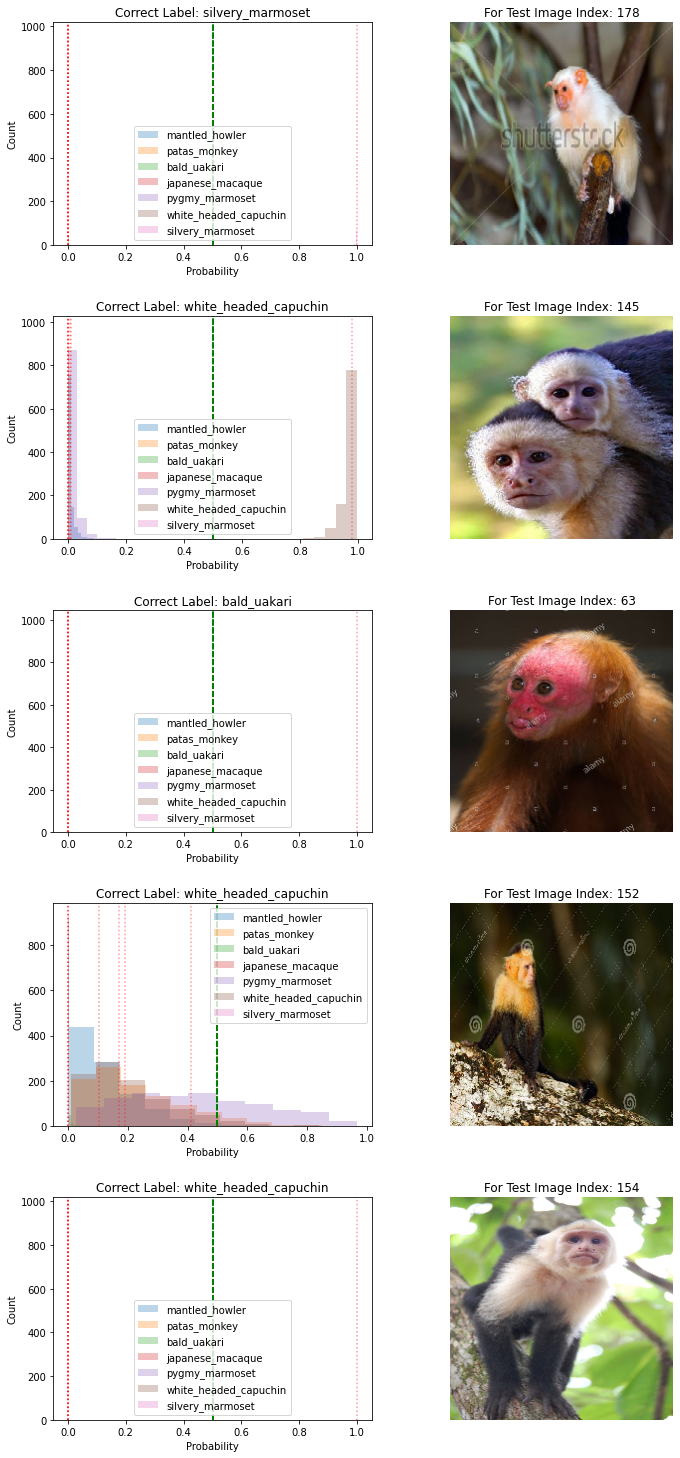

In [ ]:
pred_normal= bayesian_pred(model=model_normal, test_images=test_images, T=1000)
with open(path_data+'Pickle_Files/yt_Monkey_normal_drop.pkl', 'wb') as f:
  pickle.dump(pred_normal, f)
visualize_probdist(5, 7, pred_normal, test_images, test_labels, label_mapping)

#### Gaussian Dropout

100%|██████████| 1000/1000 [08:10<00:00,  2.04it/s]


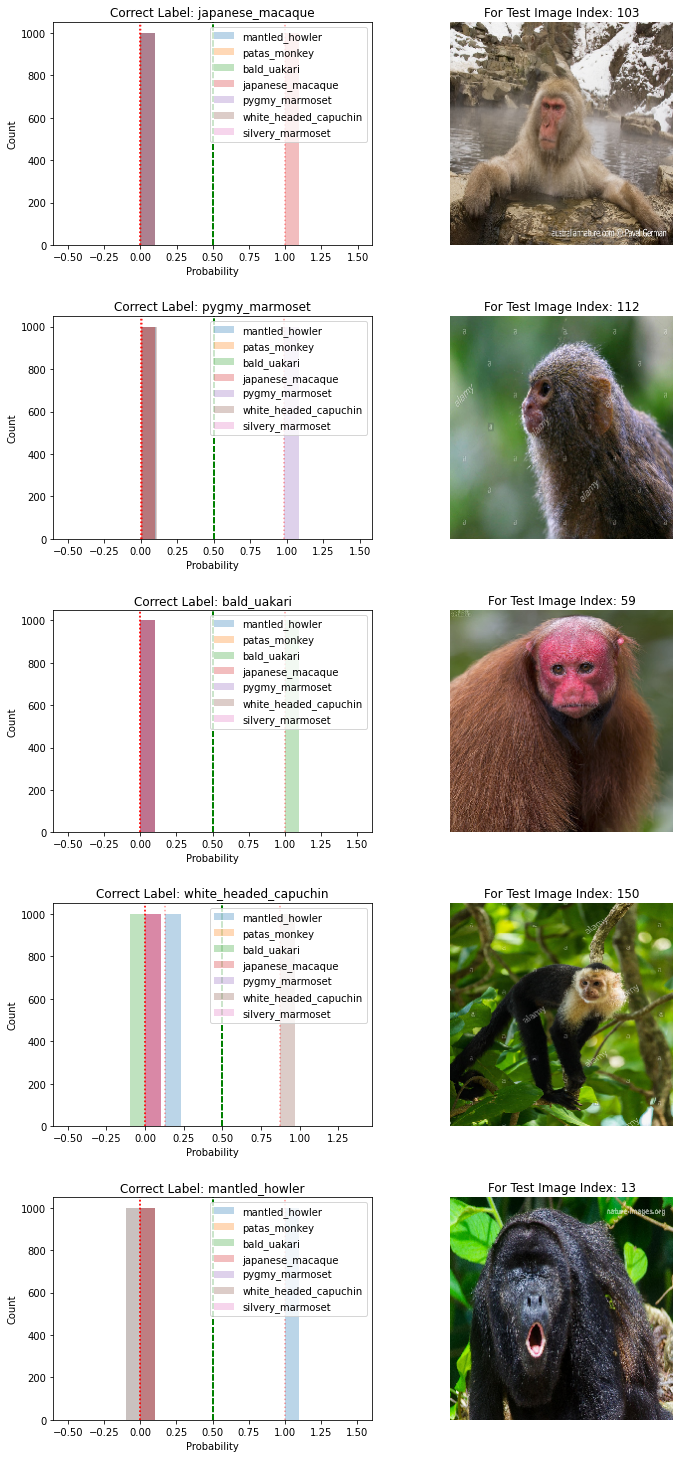

In [ ]:
pred_gaussian= bayesian_pred(model=model_gaussian, test_images=test_images, T=1000)
with open(path_data+'Pickle_Files/yt_Monkey_gaussian_drop.pkl', 'wb') as f:
  pickle.dump(pred_gaussian, f)
visualize_probdist(5, 7, pred_gaussian, test_images, test_labels, label_mapping)

### Inference For Out-of-Distribution Data

In [10]:
# Selecting classes which haven't been used for training
new_class_filter = ['n7', 'n8', 'n9']
new_label_mapping = monkey_labels['Common Name'][7:].to_dict()
new_label_mapping = {k-7: v for k, v in new_label_mapping.items()}

# Generating new Test-Data
new_test_dataset = MonkeyData(path=test_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TEST,
                              batch_size=BATCH_SIZE,
                              class_filter=new_class_filter, # Changed to new class filter
                              label_mapping=new_label_mapping) 

new_test_images, new_test_labels = new_test_dataset.get_all_data()

Found 81 images belonging to 3 classes.


#### Normal Dropout

100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]


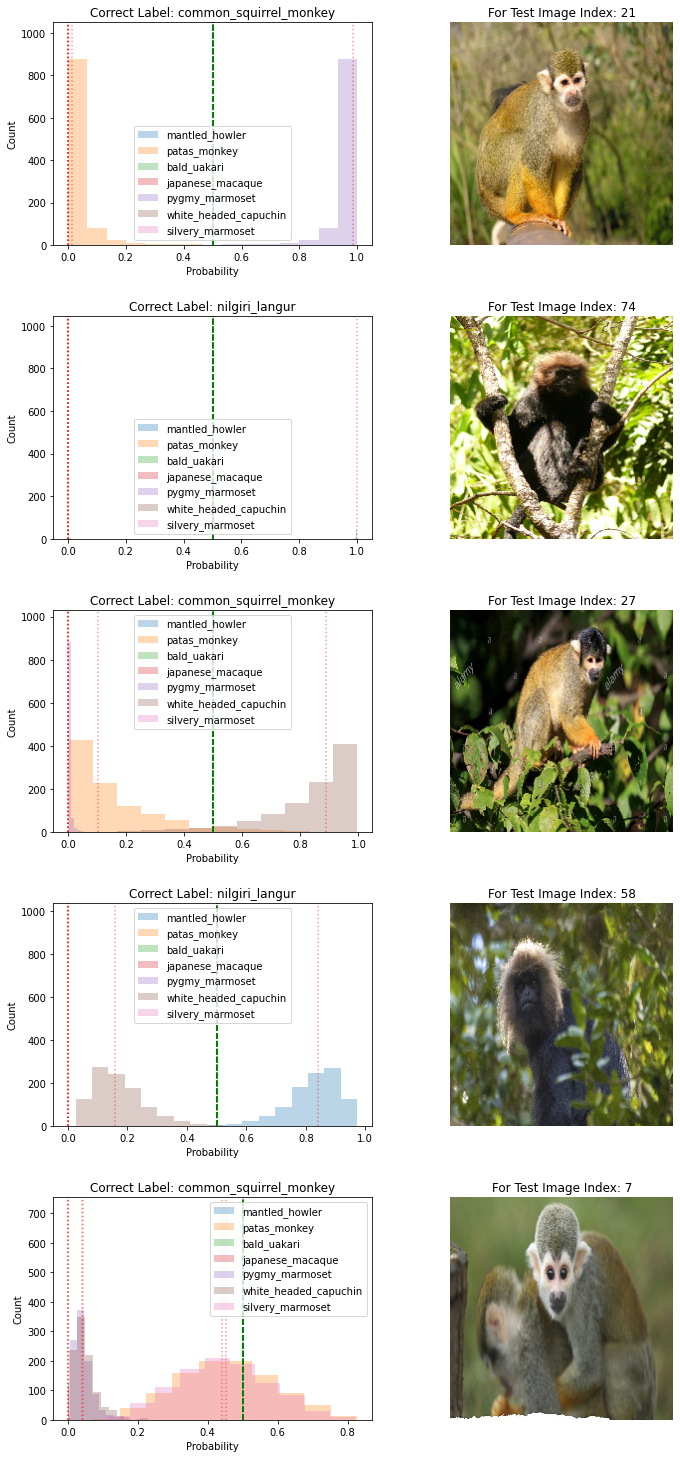

In [11]:
new_pred_normal= bayesian_pred(model=model_normal, test_images=new_test_images, T=1000)
with open(path_data+'Pickle_Files/yt_ood_Monkey_normal_drop.pkl', 'wb') as f:
  pickle.dump(new_pred_normal, f)
visualize_probdist(5, 7, new_pred_normal, new_test_images, new_test_labels, label_mapping, ood_mapping=new_label_mapping)

#### Gaussian Dropout

100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


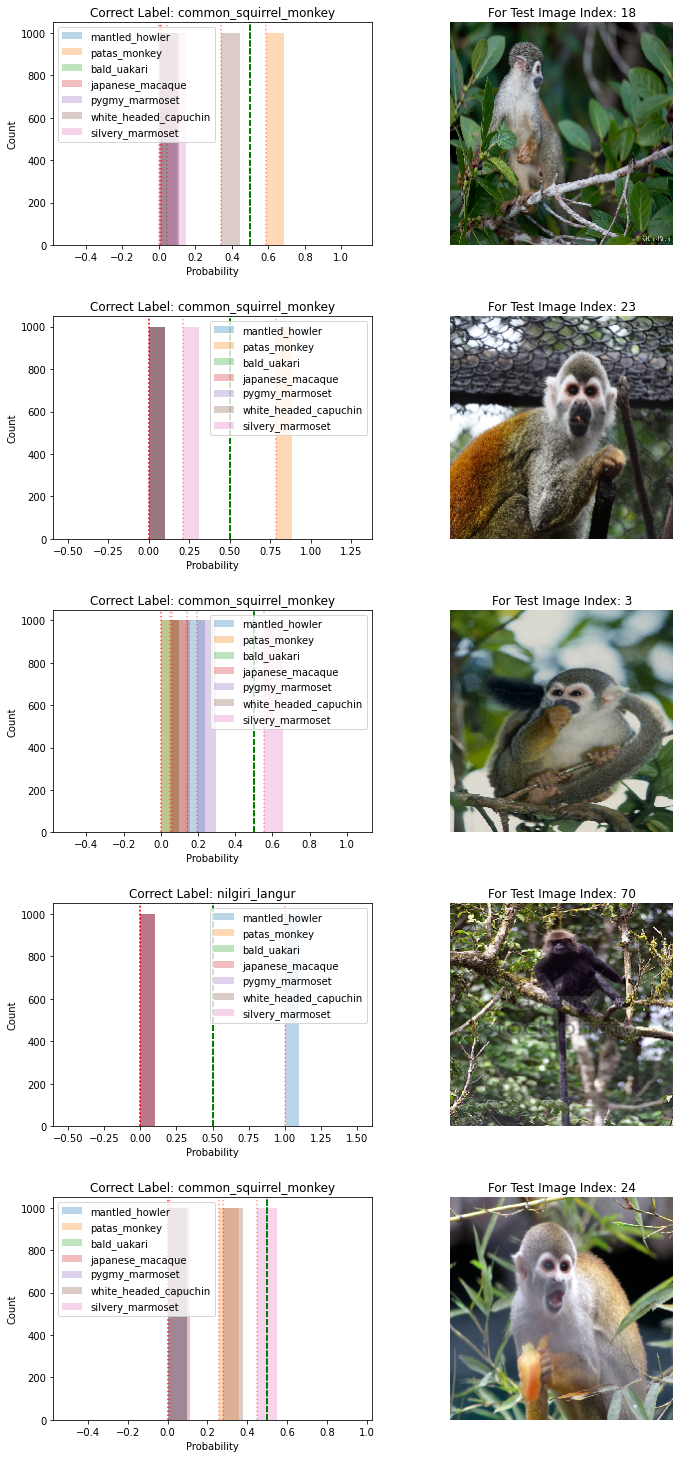

In [ ]:
new_pred_gaussian= bayesian_pred(model=model_gaussian, test_images=new_test_images, T=1000)
with open(path_data+'Pickle_Files/yt_ood_Monkey_gaussian_drop.pkl', 'wb') as f:
  pickle.dump(new_pred_gaussian, f)
visualize_probdist(5, 7, new_pred_gaussian, new_test_images, new_test_labels, label_mapping, ood_mapping=new_label_mapping)

## Results

### Training History

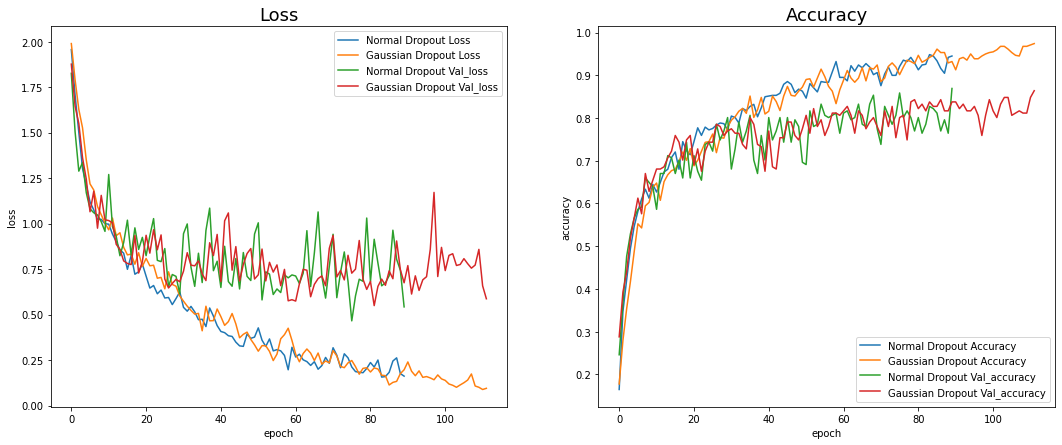

In [11]:
# Loading training-histories
normal_df=pd.read_csv(path_data+"History/history_Monkey_200ep_normal_drop_0.94_0.83", index_col=0)
gaussian_df= pd.read_csv(path_data+"History/history_Monkey_200ep_gaussian_drop_0.95_0.86", index_col=0)

# Plotting training-histories
plt.figure(figsize=(18, 7)) 
plt.subplot(1,2,1)
plt.plot(normal_df['loss'])
plt.plot(gaussian_df['loss'])
plt.plot(normal_df['val_loss'])
plt.plot(gaussian_df['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Loss', fontsize=18)
plt.legend(['Normal Dropout Loss', 'Gaussian Dropout Loss', 'Normal Dropout Val_loss', 'Gaussian Dropout Val_loss'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(normal_df['accuracy'])
plt.plot(gaussian_df['accuracy'])
plt.plot(normal_df['val_accuracy'])
plt.plot(gaussian_df['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Accuracy', fontsize=18)
plt.legend(['Normal Dropout Accuracy', 'Gaussian Dropout Accuracy', 'Normal Dropout Val_accuracy', 'Gaussian Dropout Val_accuracy'], loc='lower right')
plt.savefig('Monkey_history.png')

### RMSE and Log-likelihood

#### Test Data

##### Normal Dropout

In [23]:
with open(path_data+'Pickle_Files/yt_Monkey_normal_drop.pkl', 'rb') as f:
  yt=np.array(pickle.load(f)).squeeze()
y_test=np.array(pd.get_dummies(test_labels))
y_mc = yt.mean(axis=0)
rmse = np.mean((y_test.squeeze() - y_mc.squeeze())**2.)**0.5
ll = (logsumexp(-0.5 * 0.427114830213 * (y_test[None] - y_mc)**2., 0) - np.log(1000) - 0.5*np.log(2*np.pi) + 0.5*np.log(0.427114830213))
test_ll = np.mean(ll)

rmse, test_ll

(0.16598195127168178, -8.257929)

##### Gaussian Dropout

In [24]:
with open(path_data+'Pickle_Files/yt_Monkey_gaussian_drop.pkl', 'rb') as f:
  yt=np.array(pickle.load(f)).squeeze()
y_test=np.array(pd.get_dummies(test_labels))
y_mc = yt.mean(axis=0)
rmse = np.mean((y_test.squeeze() - y_mc.squeeze())**2.)**0.5
ll = (logsumexp(-0.5 * 0.427114830213 * (y_test[None] - y_mc)**2., 0) - np.log(1000) - 0.5*np.log(2*np.pi) + 0.5*np.log(0.427114830213))
test_ll = np.mean(ll)

rmse, test_ll

(0.1768755862896911, -8.258726)

#### Out-of-Distribution Data

##### Normal Dropout

In [33]:
with open(path_data+'Pickle_Files/yt_ood_Monkey_normal_drop.pkl', 'rb') as f:
  yt=np.array(pickle.load(f)).squeeze()
y_test=np.array(pd.get_dummies(new_test_labels).reindex(columns = pd.get_dummies(test_labels).columns, fill_value=0))
y_mc = yt.mean(axis=0)
rmse = np.mean((y_test.squeeze() - y_mc.squeeze())**2.)**0.5
ll = (logsumexp(-0.5 * 0.427114830213 * (y_test[None] - y_mc)**2., 0) - np.log(1000) - 0.5*np.log(2*np.pi) + 0.5*np.log(0.427114830213))
test_ll = np.mean(ll)

rmse, test_ll

(0.452953917775573, -8.295859989454753)

##### Gaussian Dropout

In [34]:
with open(path_data+'Pickle_Files/yt_ood_Monkey_gaussian_drop.pkl', 'rb') as f:
  yt=np.array(pickle.load(f)).squeeze()
y_test=np.array(pd.get_dummies(new_test_labels).reindex(columns = pd.get_dummies(test_labels).columns, fill_value=0))
y_mc = yt.mean(axis=0)
rmse = np.mean((y_test.squeeze() - y_mc.squeeze())**2.)**0.5
ll = (logsumexp(-0.5 * 0.427114830213 * (y_test[None] - y_mc)**2., 0) - np.log(1000) - 0.5*np.log(2*np.pi) + 0.5*np.log(0.427114830213))
test_ll = np.mean(ll)

rmse, test_ll

(0.47600325775604385, -8.300432648743456)